In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv


# Importando bibliotecas adicionais

In [2]:
import seaborn as sns
from scipy.stats import chi2_contingency
from scipy.stats import ttest_ind
from scipy.stats import shapiro
from scipy.stats import mannwhitneyu
from scipy.stats import f_oneway
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBClassifier
from catboost import CatBoostClassifier


Disclaimer: This notebook was influenced by https://www.kaggle.com/code/akankshalokhande/titanic-analysis


 # Sumário

* ## EDA
    * ### Estudos Preliminares
* ## Pre-processamento 
    * ### Fundindo train and test sets
    * ### Eliminando colunas
    * ### Normalizando
* ## Analise estatística e feature selecting
    * ### Dados Categóricos
    * ### Dados Numéricos 
    * ### Selecionando as variáveis
* ## Otimização de parâmetros
    * ### Otimizando Parametros
    * ### Calculando Métricas
* ## Treinando o 'Ensemble'

____________________________________________________________________________________________________

## Carregando os dados

In [3]:
train = pd.read_csv('/kaggle/input/titanic/train.csv')
test = pd.read_csv('/kaggle/input/titanic/test.csv')

train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# EDA - Exploratory Data Analysis

### Estudos preliminares

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [5]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


### Estatística descritiva

In [6]:
train.describe()


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


## Dados categóricos

### Contagem em relação a sobreviventes

<Axes: xlabel='Survived', ylabel='count'>

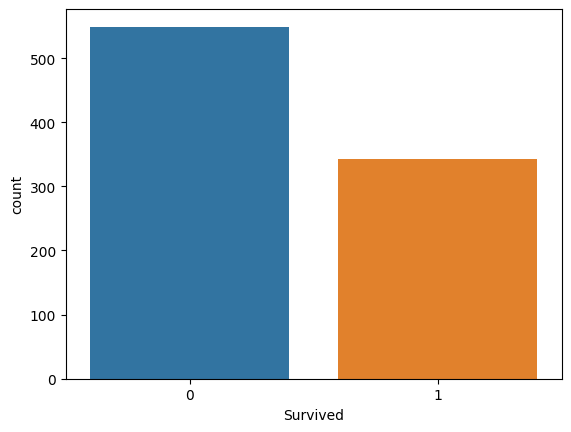

In [7]:
sns.countplot(x = train['Survived'])

### Análise da distribuição de gêneros

<Axes: xlabel='Sex', ylabel='count'>

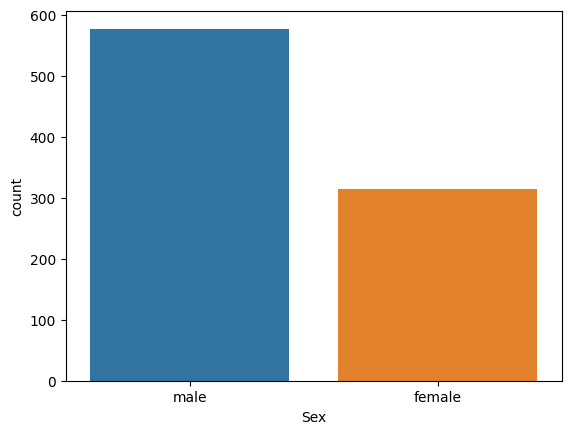

In [8]:
sns.countplot(x = train['Sex'])

#### Conclusão: havia mais homens que mulheres abordo do Titanic

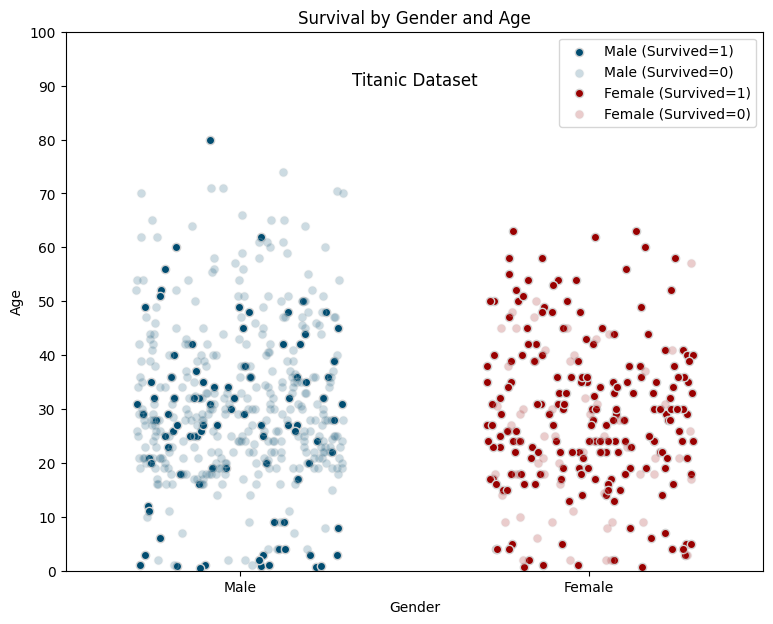

In [9]:
# Filter data for males and females
male_data = train[train['Sex'] == 'male']
female_data = train[train['Sex'] == 'female']

# Filter data for survived and not survived
male_pos = male_data[male_data['Survived'] == 1]['Age'].dropna()
male_neg = male_data[male_data['Survived'] == 0]['Age'].dropna()
female_pos = female_data[female_data['Survived'] == 1]['Age'].dropna()
female_neg = female_data[female_data['Survived'] == 0]['Age'].dropna()

# Create the plot
fig, ax = plt.subplots(1, 1, figsize=(9, 7))
np.random.seed(42)

# Male Stripplot
ax.scatter(np.random.uniform(-0.3, 0.3, len(male_pos)), male_pos, color='#004c70', edgecolor='lightgray', label='Male (Survived=1)')
ax.scatter(np.random.uniform(-0.3, 0.3, len(male_neg)), male_neg, color='#004c70', edgecolor='lightgray', alpha=0.2, label='Male (Survived=0)')

# Female Stripplot
ax.scatter(1+np.random.uniform(-0.3, 0.3, len(female_pos)), female_pos, color='#990000', edgecolor='lightgray', label='Female (Survived=1)')
ax.scatter(1+np.random.uniform(-0.3, 0.3, len(female_neg)), female_neg, color='#990000', edgecolor='lightgray', alpha=0.2, label='Female (Survived=0)')

# Set x-axis limits
ax.set_xlim(-0.5, 1.5)

# Set y-axis limits
ax.set_ylim(0, 100)

# Set x-axis ticks and labels
ax.set_xticks([0, 1])
ax.set_xticklabels(['Male', 'Female'])

# Set y-axis ticks
ax.set_yticks(range(0, 101, 10))

# Add legend
ax.legend()

# Set plot titles
ax.set_title('Survival by Gender and Age')
ax.set_xlabel('Gender')
ax.set_ylabel('Age')

# Add text annotation
ax.text(0.5, 90, 'Titanic Dataset', fontsize=12, ha='center')

plt.show()

#### Pesquisa: Quais fatores influenciaram a perspectiva de sobrevivência?
Teste chi-quadrado de independência:

In [10]:
contingency_table = pd.crosstab(train['Survived'], train['Sex'])

# Perform chi-square test
chi2, p, dof, expected = chi2_contingency(contingency_table)

print("Chi-square statistic:", chi2)
print("P-value:", p)

Chi-square statistic: 260.71702016732104
P-value: 1.1973570627755645e-58


Conclusão: Com p-value menor ainda, podemos rejeitar a hipotese nula de que o gênero e a sobrevivência não são relacionadas.
Em outras palavras, com 95% de certeza, podemos dizer que os dados corroboram com a ideia de que o gênero da pessoa influiu em sua sobrevivência

### Numero de irmãos

<Axes: xlabel='SibSp', ylabel='count'>

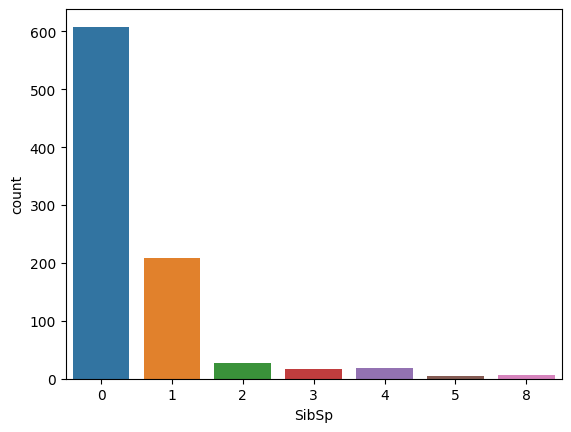

In [11]:
sns.countplot(x = train['SibSp'])

In [12]:
contingency_table = pd.crosstab(train['Survived'], train['SibSp'])

# Perform chi-square test
chi2, p, dof, expected = chi2_contingency(contingency_table)

print("Chi-square statistic:", chi2)
print("P-value:", p)

Chi-square statistic: 37.27179291520431
P-value: 1.5585810465902116e-06


#### Ter irmãos influenciou na taxa de sobrevivência das pessoas

### Parentesco de primeiro grau a bordo

<Axes: xlabel='Parch', ylabel='count'>

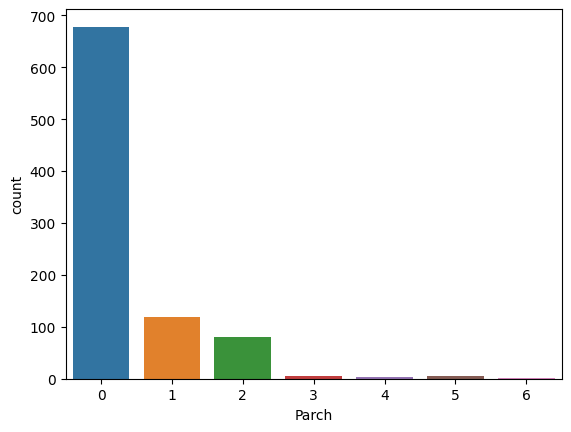

In [13]:
sns.countplot(x = train['Parch'])

In [14]:
contingency_table = pd.crosstab(train['Survived'], train['Parch'])

# Perform chi-square test
chi2, p, dof, expected = chi2_contingency(contingency_table)

print("Chi-square statistic:", chi2)
print("P-value:", p)

Chi-square statistic: 27.925784060236168
P-value: 9.703526421039997e-05


#### Conclusão: A presença de parentes de primeiro grau influenciou na taxa de sobrevivência

### Local de embarque

<Axes: xlabel='Embarked', ylabel='count'>

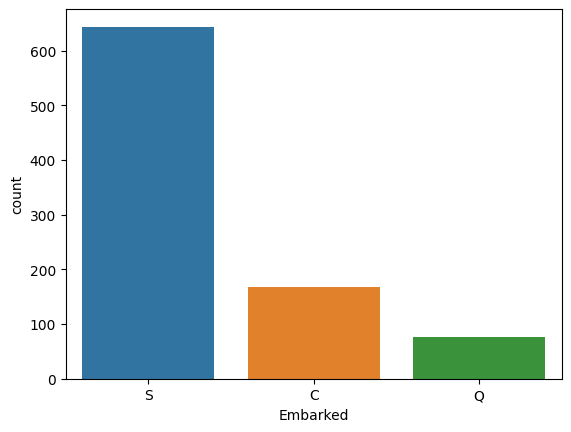

In [15]:
sns.countplot(x = train['Embarked'])

In [16]:
contingency_table = pd.crosstab(train['Survived'], train['Embarked'])

# Perform chi-square test
chi2, p, dof, expected = chi2_contingency(contingency_table)

print("Chi-square statistic:", chi2)
print("P-value:", p)

Chi-square statistic: 26.48914983923762
P-value: 1.769922284120912e-06


#### Conclusão: De alguma forma, o local de embarque influenciou na taxa de sobrevivência

### A seguir estudaremos a hipótese de que o local de embarque deve ter influenciado porque em determinados portos embarcaram pessoas de classes sociais diferentes

# Preprocessamento

### Checagem da distribuição de idade

<Axes: xlabel='Age', ylabel='count'>

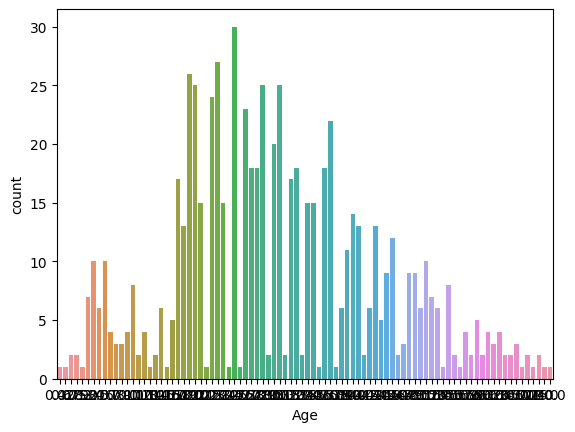

In [17]:
sns.countplot(x = train['Age'])

Esta curva me parece razoavelmente normal, logo, para fins de imputação de valores nulos, irei usar a média.

### Checagem da distribuição dos valores de tiquete

<Axes: xlabel='Fare', ylabel='count'>

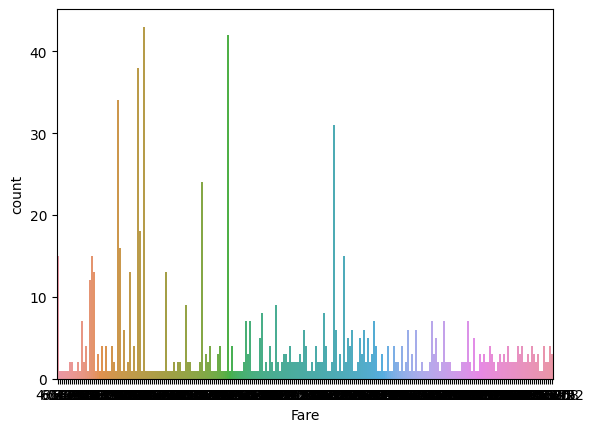

In [18]:
sns.countplot(x = train['Fare'])

Esta distribuição tem curtose relevante, indicando que imputar valores nulos pela média pode ser ruim, preferindo-se a mediana.

In [19]:
df = pd.concat([train, test], axis=0).reset_index(drop=True)
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [20]:
df = df.drop(columns=['Name', 'Ticket', 'Cabin'], axis=1)

In [21]:

df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])
df['Age'] = df['Age'].fillna(df['Age'].mean())
df['Fare'] = df['Fare'].fillna(df['Fare'].median())

df = pd.get_dummies(df, columns=['Sex', 'Embarked'], prefix=['Sex', 'Embarked'])


df.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,1,0.0,3,22.0,1,0,7.2500,False,True,False,False,True
1,2,1.0,1,38.0,1,0,71.2833,True,False,True,False,False
2,3,1.0,3,26.0,0,0,7.9250,True,False,False,False,True
3,4,1.0,1,35.0,1,0,53.1000,True,False,False,False,True
4,5,0.0,3,35.0,0,0,8.0500,False,True,False,False,True


In [22]:
df = df.drop(columns=['Sex_female', 'Embarked_Q'])  

In [23]:
scaler = MinMaxScaler()
numeric_features = ['Age', 'Fare']
df[numeric_features] = scaler.fit_transform(df[numeric_features])

In [24]:
train_len = len(train)
train = df.iloc[:train_len]
test = df.iloc[train_len:]
train.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_C,Embarked_S
0,1,0.0,3,0.273456,1,0,0.014151,True,False,True
1,2,1.0,1,0.473882,1,0,0.139136,False,True,False
2,3,1.0,3,0.323563,0,0,0.015469,False,False,True
3,4,1.0,1,0.436302,1,0,0.103644,False,False,True
4,5,0.0,3,0.436302,0,0,0.015713,True,False,True


# Análise estatística
## Dados numéricos

### Relação entre preço do ticket e local de embarque

In [25]:

# Perform ANOVA test within groups
fare_embarked_C = train[train['Embarked_C'] == 1]['Fare']
fare_embarked_S = train[train['Embarked_S'] == 1]['Fare']

f_statistic, p_value = f_oneway(fare_embarked_C, fare_embarked_S)

# Print ANOVA results
print("ANOVA F-statistic:", f_statistic)
print("P-value:", p_value)

ANOVA F-statistic: 57.64052180131622
P-value: 8.648085172116914e-14


Baseados neste valor pequeno de p-value, a hipótese nula é rejeitada e podemos concluir que a uma diferença estatisticamente significativa entre preços e locais de embarque. 

### Analise da variável Pclass

<Axes: xlabel='Pclass', ylabel='count'>

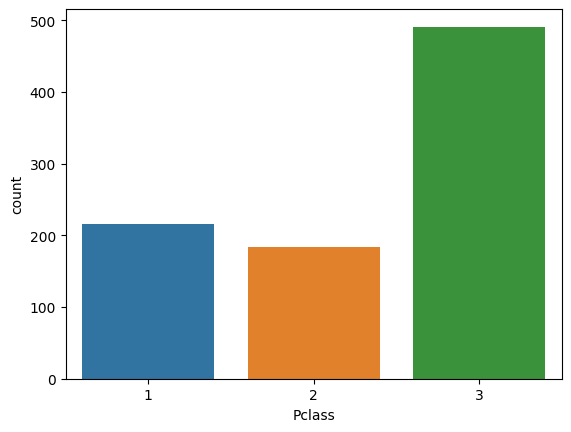

In [26]:
sns.countplot(x = train['Pclass'])

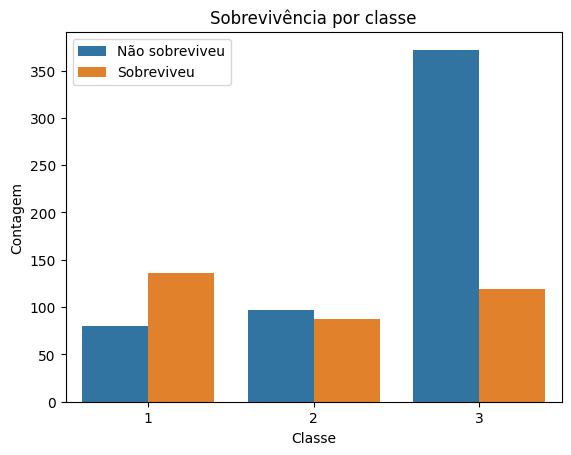

In [27]:
sns.countplot(x='Pclass', hue='Survived', data=train)
plt.title('Sobrevivência por classe')
plt.xlabel('Classe')
plt.ylabel('Contagem')
plt.xticks(rotation=0)
plt.legend(['Não sobreviveu', 'Sobreviveu'], loc='upper left')
plt.show()

In [28]:
contingency_table = pd.crosstab(train['Survived'], train['Pclass'])

# Perform chi-square test
chi2, p, dof, expected = chi2_contingency(contingency_table)

print("Chi-square statistic:", chi2)
print("P-value:", p)

Chi-square statistic: 102.88898875696056
P-value: 4.549251711298793e-23


#### Conclusão: Pclass, Embarked, Parch, SibSp e Sex devem fazer parte do rol de variáveis

### Análise da distribuição de idade

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


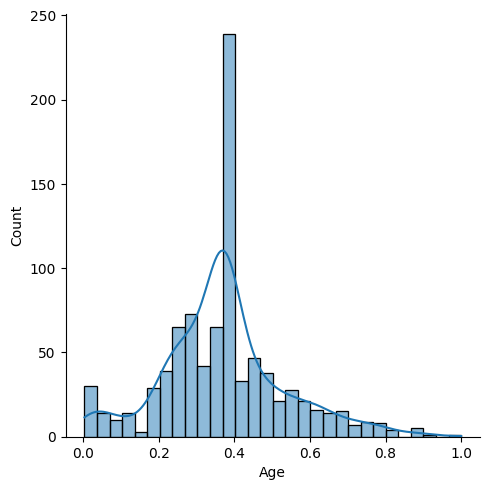

In [29]:
sns.displot(x = train['Age'], kde=True)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


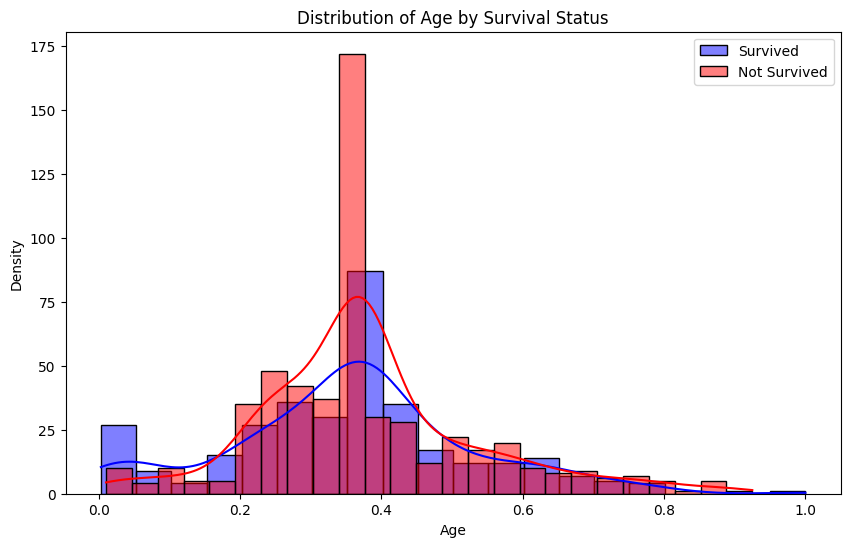

In [30]:
plt.figure(figsize=(10, 6))

sns.histplot(train[train['Survived'] == 1]['Age'], kde=True, color='blue', label='Survived', alpha=0.5)
sns.histplot(train[train['Survived'] == 0]['Age'], kde=True, color='red', label='Not Survived', alpha=0.5)

plt.xlabel('Age')
plt.ylabel('Density')
plt.title('Distribution of Age by Survival Status')
plt.legend()

plt.show()

Esta distribuição se assemelha a uma normal, usando o teste Shapiro, podemos analisar se é possível usar um teste paramétrico ou não:

In [31]:
# Perform Shapiro-Wilk test for survivors
stat_survived, p_survived = shapiro(train[train['Survived'] == 1]['Age'])
print("Shapiro-Wilk test for survivors:")
print("Test Statistic:", stat_survived)
print("P-value:", p_survived)

# Perform Shapiro-Wilk test for non-survivors
stat_not_survived, p_not_survived = shapiro(train[train['Survived'] == 0]['Age'])
print("\nShapiro-Wilk test for non-survivors:")
print("Test Statistic:", stat_not_survived)
print("P-value:", p_not_survived)

Shapiro-Wilk test for survivors:
Test Statistic: 0.9700000882148743
P-value: 1.607828608030104e-06

Shapiro-Wilk test for non-survivors:
Test Statistic: 0.9409885406494141
P-value: 5.993153157990774e-14


Conclusão: Os valores baixos de p-value indicam que a distribuição de idade entre sobreviventes e não sobreviventes desviam significativamente da normal. O que indica que não devemos usar testes paramétricos.

### Analise da distribuição de sobreviventes
O teste Mann-Whitney U busca entender se duas amostras possuem diferença significativa em sua distribuição.

In [32]:
survivors_age = train[train['Survived'] == 1]['Age']
non_survivors_age = train[train['Survived'] == 0]['Age']


statistic, p_value = mannwhitneyu(survivors_age, non_survivors_age)

print("Mann-Whitney U test statistic:", statistic)
print("P-value:", p_value)

alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis: There is a significant difference in age distributions between survivors and non-survivors.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference in age distributions between survivors and non-survivors.")


Mann-Whitney U test statistic: 89538.0
P-value: 0.24336668156689534
Fail to reject the null hypothesis: There is no significant difference in age distributions between survivors and non-survivors.


O p-value é de 0.2434. Este valor alto (maior que 0.05) indica que não podemos rejeitar a hipótese nula, de que não existe uma diferença significativa em como se distribuem as idades entre sobreviventes e não sobreviventes. Isto fica bem visível com o gráfico seguinte.

/tmp/ipykernel_33/1718943918.py:1: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=train, x='Survived', y='Age', hue='Pclass', ci=None)


<Axes: xlabel='Survived', ylabel='Age'>

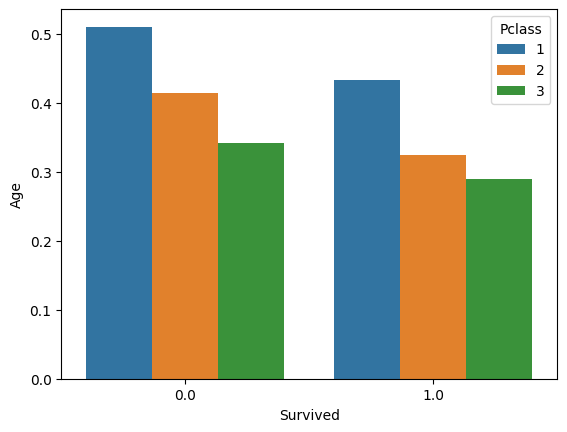

In [33]:
sns.barplot(data=train, x='Survived', y='Age', hue='Pclass', ci=None)

### Análise de acordo com o ticket pago

/tmp/ipykernel_33/554021285.py:1: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=train, x='Pclass', y='Fare', hue='Survived', ci=None)


<Axes: xlabel='Pclass', ylabel='Fare'>

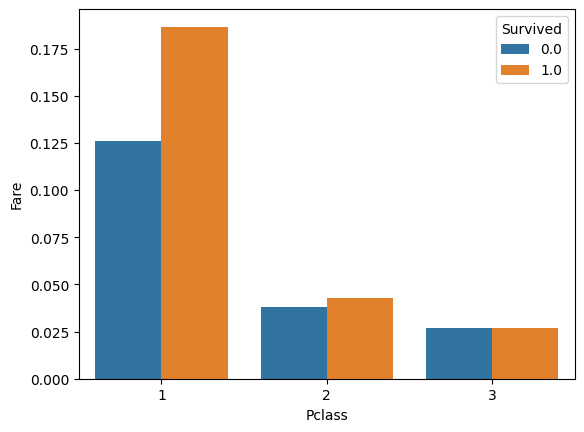

In [38]:
sns.barplot(data=train, x='Pclass', y='Fare', hue='Survived', ci=None)

In [35]:
fare_survived = train[train['Survived'] == 1]['Fare']
fare_not_survived = train[train['Survived'] == 0]['Fare']

# Perform the Mann-Whitney U test
statistic, p_value = mannwhitneyu(fare_survived, fare_not_survived)

print("Mann-Whitney U test statistic:", statistic)
print("P-value:", p_value)


Mann-Whitney U test statistic: 129951.5
P-value: 4.553477179250237e-22


#### Conclusão: O pequeníssimo valor de p-value indica que há forte correlação entre sobrevivência e o valor pago

### Definindo variáveis: 
#### Embarked_C e Embarked_S foram mantidos, pois, testando sem o resultado foi inferior.

In [36]:
features = ["Pclass", "Sex_male", "SibSp", "Parch", "Fare", "Embarked_C","Embarked_S", "Age"]
X_train = train[features]
y_train = train["Survived"]
X_test = test[features]
y_test = test["Survived"]

## Model Fitting and Optimization

### Defining best k for kNN

In [37]:
# Define a range of values for k
k_values = range(1, 70)  # Adjust the range as needed

# Initialize lists to store results
cv_scores = []

# Iterate over each value of k
for k in k_values:
    knn_model = KNeighborsClassifier(n_neighbors=k)
    # Perform cross-validation and compute the mean score
    scores = cross_val_score(knn_model, X_train, y_train, cv=5, scoring='accuracy')
    cv_scores.append(scores.mean())

# Find the best value of k
best_k = k_values[cv_scores.index(max(cv_scores))]
print("Best value of k:", best_k)

KeyboardInterrupt: 

### Grid Search for XGB boost

In [ ]:
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'n_estimators': [50, 100, 200],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}
grid_search = GridSearchCV(estimator=XGBClassifier(), param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)
best_xgb_model = grid_search.best_estimator_

### Grid Search for Random Forest

In [ ]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}


rf_model = RandomForestClassifier(random_state=42)


grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)


best_params = grid_search.best_params_
best_score = grid_search.best_score_


best_model = grid_search.best_estimator_


In [ ]:
# classify column
def classify(model, X_train, y_train, X_test, y_test):
    x_train_split, x_test_split, y_train_split, y_test_split = train_test_split(X_train, y_train, test_size=0.25, random_state=42)
    
    model.fit(x_train_split, y_train_split)
    
    # Predict on the test set
    y_pred = model.predict(x_test_split)
    

    
    # Calculate evaluation metrics
    accuracy = model.score(x_test_split, y_test_split)
    precision = precision_score(y_test_split, y_pred)
    recall = recall_score(y_test_split, y_pred)
    f1 = f1_score(y_test_split, y_pred)
    confusion = confusion_matrix(y_test_split, y_pred)
    # Calcular as probabilidades para a curva ROC
    y_probs = model.predict_proba(x_test_split)[:,1]
    fpr, tpr, thresholds = roc_curve(y_test_split, y_probs)
    roc_auc = roc_auc_score(y_test_split, y_probs)
    
    print('Accuracy:', accuracy)
    print('Precision:', precision)
    print('Recall:', recall)
    print('F1 Score:', f1)
    print('Confusion Matrix:')
    print(confusion)
    
    # Plotar a curva ROC
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()
    
    return model.predict(x_test_split)

In [ ]:
model = LogisticRegression()
predictions = classify(model, X_train, y_train, X_test, y_test)

In [ ]:
model = KNeighborsClassifier(n_neighbors=best_k)
predictions = classify(model, X_train, y_train, X_test, y_test)


In [ ]:
model = RandomForestClassifier(**grid_search.best_params_)
predictions = classify(model, X_train, y_train, X_test, y_test)


In [ ]:
model = XGBClassifier(**grid_search.best_params_)
predictions = classify(model, X_train, y_train, X_test, y_test)


In [ ]:
model = CatBoostClassifier(logging_level='Silent')
predictions = classify(model, X_train, y_train, X_test, y_test)


In [ ]:

models = {
    'Random Forest': RandomForestClassifier(**grid_search.best_params_),
    'KNN': KNeighborsClassifier(n_neighbors=best_k),
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'XGBoost': best_xgb_model,
    'CatBoost': CatBoostClassifier(logging_level='Silent')
}

### Voting Classifier Ensemble

In [ ]:
models_list = list(models.items())
ensemble = VotingClassifier(estimators=models_list, voting='soft')

In [ ]:
predictions = classify(ensemble, X_train, y_train, X_test, y_test)

In [ ]:
def classify(model, X_train, y_train, X_test, y_test):
    # Split the training data into training and validation sets
    x_train_split, x_val, y_train_split, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)
    
    # Further split the training data into training and validation sets
    x_train_split, x_test_split, y_train_split, y_test_split = train_test_split(x_train_split, y_train_split, test_size=0.25, random_state=42)
    
    # Train individual models on the training data and evaluate them on a validation set
    validation_predictions = {}
    for name, model in models.items():
        model.fit(x_train_split, y_train_split)
        y_pred_val = model.predict(x_val)
        validation_predictions[name] = y_pred_val

    # Calculate accuracies on the validation set for each model
    accuracies = {name: accuracy_score(y_val, preds) for name, preds in validation_predictions.items()}

    # Determine weights based on model accuracies (you can use other metrics as well)
    total_accuracy = sum(accuracies.values())
    weights = {name: acc / total_accuracy for name, acc in accuracies.items()}

    # Use the weights to create the ensemble with weighted averaging
    weighted_models_list = [(name, model) for (name, model) in models_list]
    ensemble = VotingClassifier(estimators=weighted_models_list, voting='soft', weights=[weights[name] for name, _ in weighted_models_list])

    # Train the ensemble on the entire training data
    ensemble.fit(X_train, y_train)

    # Make predictions on the test set
    predictions = ensemble.predict(x_test_split)
    accuracy = accuracy_score(y_test_split, predictions)
    precision = precision_score(y_test_split, predictions)
    recall = recall_score(y_test_split, predictions)
    f1 = f1_score(y_test_split, predictions)
    confusion = confusion_matrix(y_test_split, predictions)
    
    print('Accuracy:', accuracy)
    print('Precision:', precision)
    print('Recall:', recall)
    print('F1 Score:', f1)
    print('Confusion Matrix:')
    print(confusion)
    
    # Plot ROC curve
    y_probs = model.predict_proba(x_test_split)[:,1]
    fpr, tpr, thresholds = roc_curve(y_test_split, y_probs)
    roc_auc = roc_auc_score(y_test_split, y_probs)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()
    
    return accuracy, precision, recall, f1, confusion


In [ ]:
    # Now use the ensemble to make predictions on the test set
    predictions = classify(ensemble, X_train, y_train, X_test, y_test)
    print(predictions)

In [ ]:
predictions = ensemble.predict(X_test) 

In [ ]:
output = pd.DataFrame({'PassengerId': test['PassengerId'], 'Survived': predictions.astype(int)})
output.to_csv('/kaggle/working/submission.csv', index=False)
print("Your submission was successfully saved!")